# Demo example: filling gaps

This example is the continuation of the previous example: [Apply quality control](https://metobs-toolkit.readthedocs.io/en/latest/examples/qc_example.html). This example serves as a demonstration of how to fill gaps. 

In [1]:
import metobs_toolkit
metobs_toolkit.add_StreamHandler(setlvl='WARNING')

your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

## Finding Gaps

When you import your datafile, the toolkit will look for gaps in your data. This is done by assuming that each station has a perfect frequency of observations (i.g. 5 minutes), a start timestamp, and an end timestamp. The toolkit can construct a perfect set of timestamps for which an observation is expected. The toolkit will try to find an observation for each (perfect) timestamp, using timestamp tolerances if specified. 

When it is not possible to assign an observation to a timestamp, we have a *gap*. If multiple consecutive timestaps could not be matched to observations, we also have a gap but the gap spans a longer period.  


In [2]:
your_dataset.import_data_from_file(
        freq_estimation_method="highest", #which method to use for estimating a frequency
        freq_estimation_simplify_tolerance="2min", #tolerance for simplifying a frequency
        origin_simplify_tolerance="5min", #tolerance for simplifying an origin (=start timestap per station)
        timestamp_tolerance="4min") #tolerance for mapping an observation to a (perfect) timestamp

your_dataset.coarsen_time_resolution(freq='15T')

The following data columns are renamed because of special meaning by the toolkit: {}
Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following metadata columns are renamed because of special meaning by the toolkit: {}
LOG:: metobs_toolkit.dataset_core - WARNING - These stations will be removed because of only having one record: []
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datasetbase.py:801: Futur

These missing observations are indicated in time series plots as vertical lines:

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


<Axes: title={'center': 'Temperatuur of vlinder02'}, xlabel='datetime', ylabel='temp (Celsius)'>

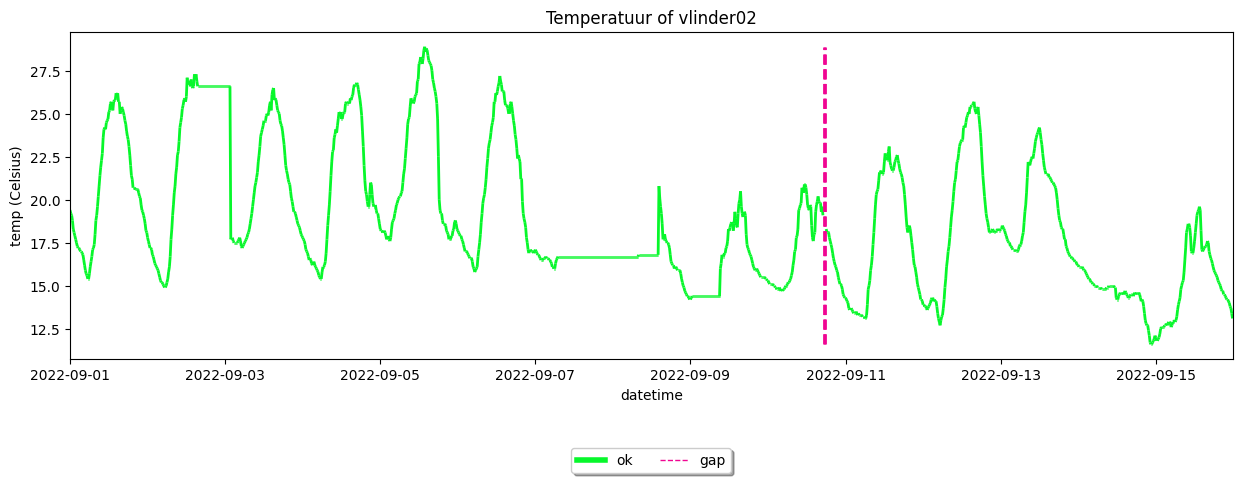

In [3]:
your_dataset.get_station('vlinder02').make_plot(colorby='label')

## Inspect gaps

The gaps are stored in the form of at the `.gaps` attribute of a Dataset. 
Each gap is defined by 
* an observationtype
* a station name
* a start timestamp
* a end timestamp

In [4]:
your_dataset.gaps

[humidity-gap of vlinder02 for 2022-09-10 17:15:00+00:00 --> 2022-09-10 17:15:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 humidity-gap of vlinder02 for 2022-09-10 17:45:00+00:00 --> 2022-09-10 17:45:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 temp-gap of vlinder02 for 2022-09-10 17:15:00+00:00 --> 2022-09-10 17:15:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 temp-gap of vlinder02 for 2022-09-10 17:45:00+00:00 --> 2022-09-10 17:45:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 wind_direction-gap of vlinder02 for 2022-09-10 17:15:00+00:00 --> 2022-09-10 17:15:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 wind_direction-gap of vlinder02 for 2022-09-10 17:45:00+00:00 --> 2022-09-10 17:45:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 wind_speed-gap of vlinder02 for 2022-09-10 17:15:00+00:00 --> 2022-09-10 17:15:00+00:00, duration: 0 days 00:00:00 or 1 records.,
 wind_speed-gap of vlinder02 for 2022-09-10 17:45:00+00:00 --> 2022-09-10 17:45:00+00:00, d

To have a tabular representation of the present gaps, use the ´.get_gaps_fill_df()` method. This method returns a dataframe that contains all the records present in the gaps. When gapfill methods are applied, the filled values appear in this dataframe.

In [5]:
your_dataset.get_gaps_fill_df()

value fill_method   msg
name      obstype        datetime                                          
vlinder02 humidity       2022-09-10 17:15:00+00:00    NaN  not filled  None
                         2022-09-10 17:45:00+00:00    NaN  not filled  None
          temp           2022-09-10 17:15:00+00:00    NaN  not filled  None
                         2022-09-10 17:45:00+00:00    NaN  not filled  None
          wind_direction 2022-09-10 17:15:00+00:00    NaN  not filled  None
                         2022-09-10 17:45:00+00:00    NaN  not filled  None
          wind_speed     2022-09-10 17:15:00+00:00    NaN  not filled  None
                         2022-09-10 17:45:00+00:00    NaN  not filled  None

## Outliers to gaps and missing observations

In practice, the observations that are labeled as outliers are often interpreted as gaps (because we assume that the observation value is erroneous) so that they can be filled. In the toolkit it is possible to convert the outliers to gaps by using the ``convert_outliers_to_gaps()``.

LOG:: metobs_toolkit.qc_checks - WARNING - The windows are too small for stations  ['vlinder01', 'vlinder02', 'vlinder03', 'vlinder04', 'vlinder05', 'vlinder06', 'vlinder07', 'vlinder08', 'vlinder09', 'vlinder10', 'vlinder11', 'vlinder12', 'vlinder13', 'vlinder14', 'vlinder15', 'vlinder16', 'vlinder17', 'vlinder18', 'vlinder19', 'vlinder20', 'vlinder21', 'vlinder22', 'vlinder23', 'vlinder24', 'vlinder25', 'vlinder26', 'vlinder27', 'vlinder28'] to perform persistance check
LOG:: metobs_toolkit.dataset_gap_handling - WARNING - The current gaps will be removed and new gaps are formed!
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, 

<Axes: title={'center': 'Temperatuur for all stations. '}, xlabel='datetime', ylabel='temp (Celsius)'>

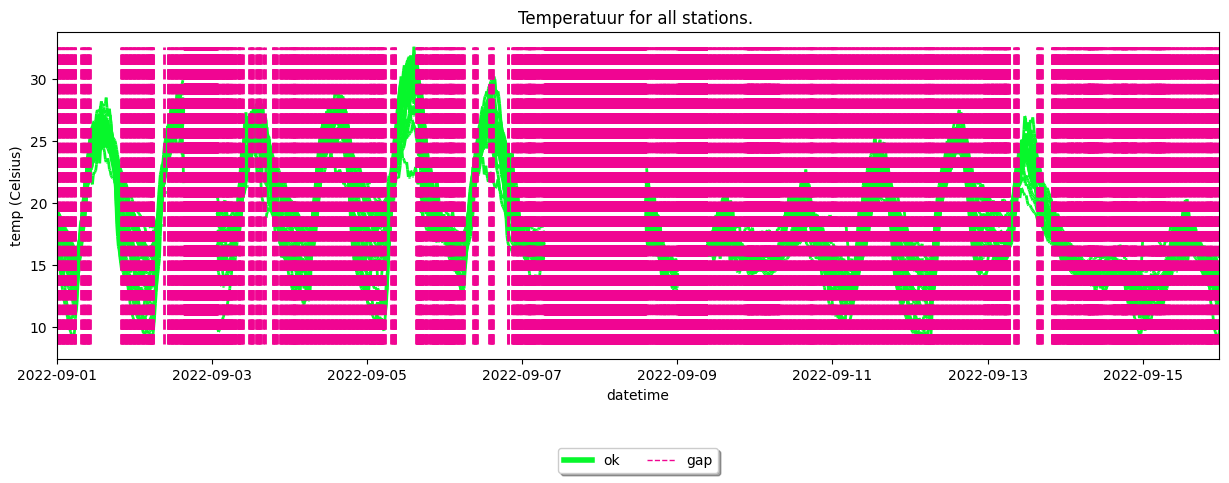

In [6]:
#first apply (default) quality control
your_dataset.apply_quality_control(obstype='temp') #we use the default settings in this example

#Interpret the outliers as missing observations and gaps.
your_dataset.convert_outliers_to_gaps()
#Inspect your gaps
your_dataset.make_plot(colorby='label')

When plotting a single station, the figure becomes more clear

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


<Axes: title={'center': 'Temperatuur of vlinder05'}, xlabel='datetime', ylabel='temp (Celsius)'>

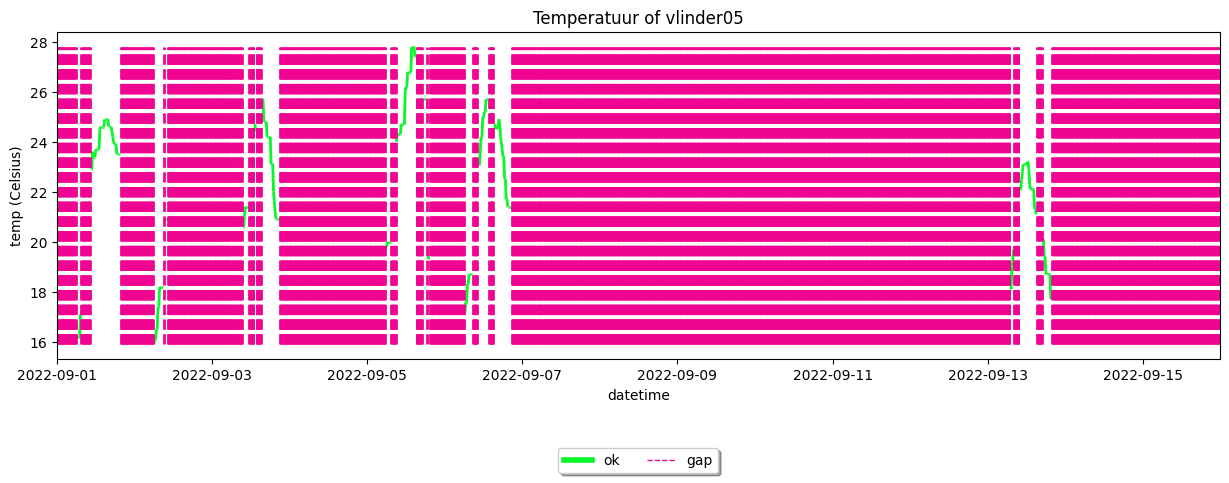

In [7]:
your_dataset.get_station('vlinder05').make_plot(colorby='label')

## Fill gaps

In the toolkit, two groups of methods are implemented: **interpolation methods** and by making **use of external modeldata**. 

**NOTE**: In this example, we use a single station (vlinder05) for demonstration. All methods can be directly applied on 
a Dataset, you do not need to apply this on all stations separately.

### Interpolation methods

The most straightforward method to fill a gap is by using interpolation. Linear interpolation is the best-known form of interpolation, but there are also more advanced forms of interpolation. In the toolkit, we can easily interpolate the gaps by making use of the ``Dataset.interpolate_gaps()`` method.

LOG:: metobs_toolkit.gap - WARNING - Cannot fill temp-gap of vlinder05 for 2022-09-01 00:00:00+00:00 --> 2022-09-01 05:45:00+00:00, duration: 0 days 05:45:00 or 24 records., because leading record is not valid.
LOG:: metobs_toolkit.gap - WARNING - Cannot fill temp-gap of vlinder05 for 2022-09-13 20:00:00+00:00 --> 2022-09-15 23:45:00+00:00, duration: 2 days 03:45:00 or 208 records., because trailing record is not valid.
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


<Axes: title={'center': 'Temperatuur of vlinder05'}, xlabel='datetime', ylabel='temp (Celsius)'>

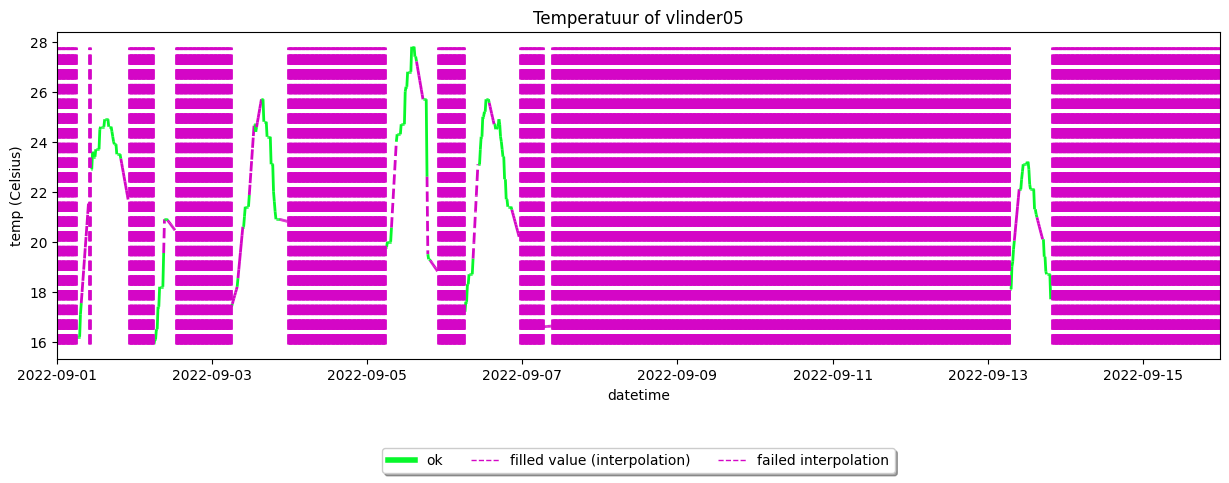

In [8]:
your_dataset.interpolate_gaps(obstype='temp', #Which gaps to fill
                              overwrite_fill = True, #Overwrite previous filled values if they are present
                              method='linear', #which interpolation method
                              max_consec_fill=10, #maximum number of consecutive missing records to fill.
                              )
your_dataset.get_station('vlinder05').make_plot(colorby='label')

As you can see, some gaps are (partially) filled others are not filled. This is because a filling criterea was not matched. By using the ``Dataset.get_gaps_fill_df()`` method, it becomes clear why some gaps could not be filled.

In [9]:
your_dataset.get_station('vlinder05').get_gaps_fill_df()

value           fill_method  \
name      obstype datetime                                                 
vlinder05 temp    2022-09-01 00:00:00+00:00    NaN  failed interpolation   
                  2022-09-01 00:15:00+00:00    NaN  failed interpolation   
                  2022-09-01 00:30:00+00:00    NaN  failed interpolation   
                  2022-09-01 00:45:00+00:00    NaN  failed interpolation   
                  2022-09-01 01:00:00+00:00    NaN  failed interpolation   
...                                            ...                   ...   
                  2022-09-15 22:45:00+00:00    NaN  failed interpolation   
                  2022-09-15 23:00:00+00:00    NaN  failed interpolation   
                  2022-09-15 23:15:00+00:00    NaN  failed interpolation   
                  2022-09-15 23:30:00+00:00    NaN  failed interpolation   
                  2022-09-15 23:45:00+00:00    NaN  failed interpolation   

                                                                                         msg  
name      obstype datetime                                                                    
vlinder05 temp    2022-09-01 00:00:00+00:00   to few leading records (0 found but 1 needed).  
                  2022-09-01 00:15:00+00:00   to few leading records (0 found but 1 needed).  
                  2022-09-01 00:30:00+00:00   to few leading records (0 found but 1 needed).  
                  2022-09-01 00:45:00+00:00   to few leading records (0 found but 1 needed).  
                  2022-09-01 01:00:00+00:00   to few leading records (0 found but 1 needed).  
...                                                                                      ...  
                  2022-09-15 22:45:00+00:00  to few trailing records (0 found but 1 needed).  
                  2022-09-15 23:00:00+00:00  to few trailing records (0 found but 1 needed).  
                  2022-09-15 23:15:00+00:00  to few trailing records (0 found but 1 needed).  
                  2022-09-15 23:30:00+00:00  to few trailing records (0 found but 1 needed).  
                  2022-09-15 23:45:00+00:00  to few trailing records (0 found but 1 needed).  

[1219 rows x 3 columns]

If you are interested in all details of a specific gap, you can find that gap using the ``Dataset.find_gap()`` method, and then inspect the specific ``Gap()``.

In [10]:
from datetime import datetime

gap_of_interest = your_dataset.get_station('vlinder05').find_gap(stationname='vlinder05',
                                                                 obstype='temp',
                                                                 in_gap_timestamp = datetime(2022,9,3,1)) #2022-09-03 01:00:00

gap_of_interest.get_info()

#or inspect the gapdf
gap_of_interest.gapdf

---- Gap info -----
(Note: gaps start and end are defined on the frequency estimation of the native dataset.)
  * Gap for station: vlinder05
  * Start gap: 2022-09-02 10:15:00+00:00
  * End gap: 2022-09-03 05:45:00+00:00
  * Duration gap: 0 days 19:30:00
  * For temp
  * Gapfill status >>>> Partially filled gap
---- Anchor Data Frame ----- 
                                     temp      fill_method msg
name      datetime                                            
vlinder05 2022-09-02 10:00:00+00:00  20.9   leading period  ok
          2022-09-03 06:00:00+00:00  17.4  trailing period  ok
---- Gap Data Frame -----
                                     temp  temp_fill           fill_method  \
name      datetime                                                           
vlinder05 2022-09-02 10:15:00+00:00   NaN   20.85625         interpolation   
          2022-09-02 10:30:00+00:00   NaN   20.81250         interpolation   
          2022-09-02 10:45:00+00:00   NaN   20.76875         interp

temp  temp_fill           fill_method  \
name      datetime                                                           
vlinder05 2022-09-02 10:15:00+00:00   NaN   20.85625         interpolation   
          2022-09-02 10:30:00+00:00   NaN   20.81250         interpolation   
          2022-09-02 10:45:00+00:00   NaN   20.76875         interpolation   
          2022-09-02 11:00:00+00:00   NaN   20.72500         interpolation   
          2022-09-02 11:15:00+00:00   NaN   20.68125         interpolation   
...                                   ...        ...                   ...   
          2022-09-03 04:45:00+00:00   NaN        NaN  failed interpolation   
          2022-09-03 05:00:00+00:00   NaN        NaN  failed interpolation   
          2022-09-03 05:15:00+00:00   NaN        NaN  failed interpolation   
          2022-09-03 05:30:00+00:00   NaN        NaN  failed interpolation   
          2022-09-03 05:45:00+00:00   NaN        NaN  failed interpolation   

                                                                   msg  
name      datetime                                                      
vlinder05 2022-09-02 10:15:00+00:00                ok (method: linear)  
          2022-09-02 10:30:00+00:00                ok (method: linear)  
          2022-09-02 10:45:00+00:00                ok (method: linear)  
          2022-09-02 11:00:00+00:00                ok (method: linear)  
          2022-09-02 11:15:00+00:00                ok (method: linear)  
...                                                                ...  
          2022-09-03 04:45:00+00:00  Permitted_by_max_consecutive_fill  
          2022-09-03 05:00:00+00:00  Permitted_by_max_consecutive_fill  
          2022-09-03 05:15:00+00:00  Permitted_by_max_consecutive_fill  
          2022-09-03 05:30:00+00:00  Permitted_by_max_consecutive_fill  
          2022-09-03 05:45:00+00:00  Permitted_by_max_consecutive_fill  

[79 rows x 4 columns]

### Higher order interpolation demo

When using more advanced interpolation methods, often multiple **anchors** (= the good records that serve as anchor points for the interpolation). In the toolkit we will refer to a **leading period** and a **trailing period**, the anchor's observations before and after the gaps respectively. 

Here is an example on applying a polynomial interpolation on gaps.

LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder04 for 2022-09-02 15:30:00+00:00 --> 2022-09-03 01:30:00+00:00, duration: 0 days 10:00:00 or 41 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder04 for 2022-09-07 06:30:00+00:00 --> 2022-09-08 14:00:00+00:00, duration: 1 days 07:30:00 or 127 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder04 for 2022-09-09 00:30:00+00:00 --> 2022-09-09 09:00:00+00:00, duration: 0 days 08:30:00 or 35 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder04 for 2022-09-10 02:15:00+00:00 --> 2022-09-10 05:00:00+00:00, duration: 0 days 02:45:00 or 12 records., will be overwritten!
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future versi

<Axes: title={'center': 'Temperatuur of vlinder04'}, xlabel='datetime', ylabel='temp (Celsius)'>

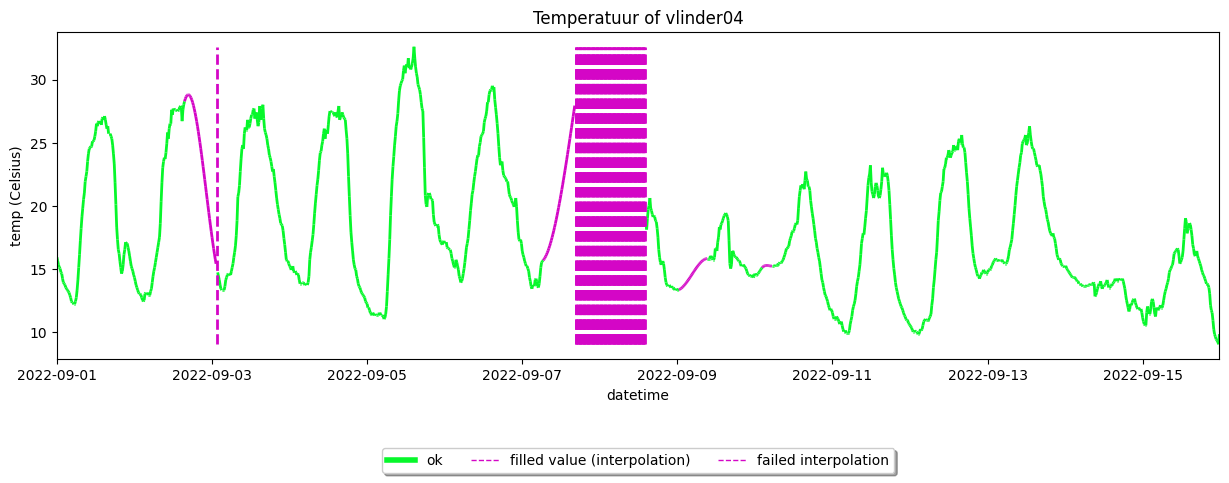

In [11]:

your_dataset.get_station('vlinder04').interpolate_gaps(
                          method='polynomial',
                          overwrite_fill=True,
                          n_leading_anchors=3, #at least 3 leading anchors are needed for 3th order polynomial interpolation
                          n_trailing_anchors=4, #at least 3 trailing anchors are needed for 3th order polynomial interpolation
                          max_consec_fill=40, 
                          max_lead_to_gap_distance='60min', #the maximum distance (in time) beween the leading anchors and the start of the gap.
                          method_kwargs={'order':3}, #all extra arguments to pass to the pandas.Dataframe.interpolate method.
)

your_dataset.get_station('vlinder04').make_plot(colorby='label')

## Fill gaps using external modeldata

As an example, we will fill the gaps using bias-corrected ERA5 data. For more info on how to download ERA5 data in the toolkit, see [Demo example: Using a Google Earth engine](https://metobs-toolkit.readthedocs.io/en/latest/examples/gee_example.html#Extracting-ERA5-timeseries).


LOG:: metobs_toolkit.gap - WARNING - Cannot fill temp-gap of vlinder05 for 2022-09-01 00:00:00+00:00 --> 2022-09-01 05:45:00+00:00, duration: 0 days 05:45:00 or 24 records., because leading period is not valid.
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-01 07:30:00+00:00 --> 2022-09-01 10:15:00+00:00, duration: 0 days 02:45:00 or 12 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-01 19:45:00+00:00 --> 2022-09-02 05:45:00+00:00, duration: 0 days 10:00:00 or 41 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-02 09:00:00+00:00 --> 2022-09-02 09:00:00+00:00, duration: 0 days 00:00:00 or 1 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-02 10:15:00+00:00 --> 2022-09-03 05:45:00+00:00, duration: 0 days 19:30:00 or 79 records., will be overwritten

(When using the .set_model_from_csv() method, make sure the modelname of your Modeldata is ERA5_hourly)


LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-03 06:15:00+00:00 --> 2022-09-03 07:30:00+00:00, duration: 0 days 01:15:00 or 6 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-03 08:00:00+00:00 --> 2022-09-03 09:15:00+00:00, duration: 0 days 01:15:00 or 6 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-03 11:30:00+00:00 --> 2022-09-03 12:45:00+00:00, duration: 0 days 01:15:00 or 6 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-03 13:45:00+00:00 --> 2022-09-03 15:00:00+00:00, duration: 0 days 01:15:00 or 6 records., will be overwritten!
LOG:: metobs_toolkit.gap - WARNING - The filling of temp-gap of vlinder05 for 2022-09-03 21:00:00+00:00 --> 2022-09-05 05:30:00+00:00, duration: 1 days 08:30:00 or 131 records., will be overwritten!
LOG:: metobs_

<Axes: title={'center': 'Temperatuur of vlinder05'}, xlabel='datetime', ylabel='temp (Celsius)'>

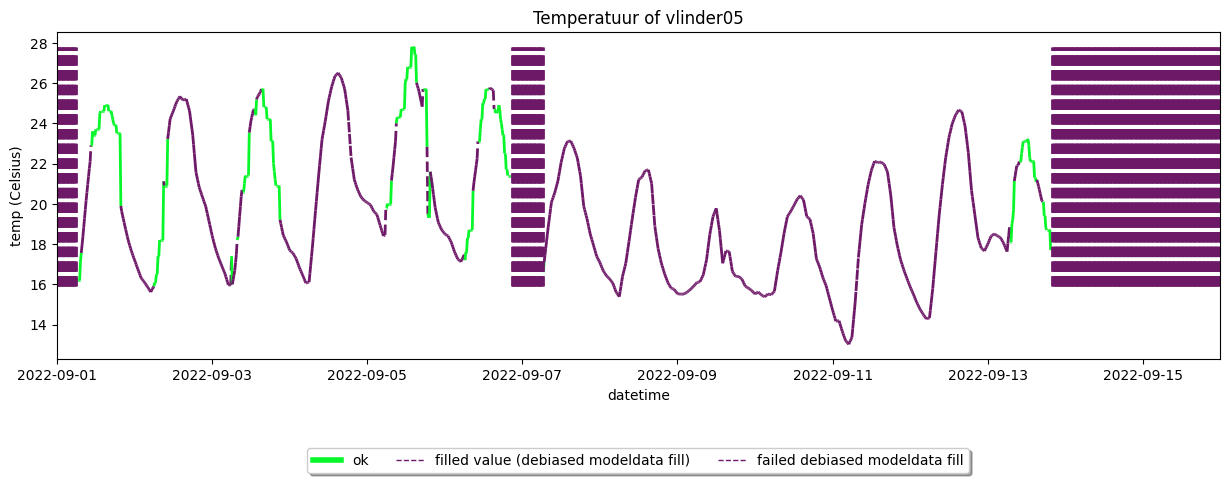

In [12]:

#as a demonstration, we use a single station to fill the gaps of. All methods can be directly applied on a full Dataset.
your_station = your_dataset.get_station('vlinder05') 

#Extract time series at the location of the station
ERA5_data = your_station.get_modeldata(modelname='ERA5_hourly',
                                      obstype='temp',
                                      startdt=None, #if None, the start of the observations is used
                                      enddt=None, #if None, the end of the observations is used
                                      )

#Use a debiased gapfill method to fill the gaps:
your_station.fill_gaps_with_debiased_modeldata(
            Modeldata=ERA5_data,
            obstype="temp",
            overwrite_fill=True,
            leading_period_duration="24h", #leading period definition for bias calculation
            min_leading_records_total=4, # minimum size of leading period (in records)
            trailing_period_duration="24h", #trailing period definition for bias calculation
            min_trailing_records_total=4, # minimum size of trailing period (in records)
        )


your_station.make_plot(colorby='label')

The following modeldata-gapfill methods are implemented in the toolkit:

* ``Dataset.fill_gaps_with_raw_modeldata()``
* ``Dataset.fill_gaps_with_debiased_modeldata()``
* ``Dataset.fill_gaps_with_diurnal_debiased_modeldata()``
* ``Dataset.fill_gaps_with_weighted_diurnal_debias_modeldata()``

For more information, see the Documentation of the methods. 

## Filling gaps exercise

For a more detailed reference you can use this [Filling gaps exercise](https://github.com/vergauwenthomas/MetObs_toolkit/blob/4d5a35954eb8ff153eb0d9e9c8a34cee7e3c50f4/fairness_demo_exercises/Gap_filling_excercise_03.ipynb), which was created in the context of the [COST FAIRNESS](https://www.cost.eu/actions/CA20108/) summer school 2023 in Ghent.